In [2]:
import numpy as np
import pandas as pd
import cv2

In [31]:
df1 = pd.read_csv('TMNIST_Data.csv')
df1 = df1.drop(['names'], axis=1)
df2 = pd.read_csv('MNIST_Data.csv')
cols = list(range(1,785))
df1.columns = ['labels'] + cols
df2.columns = ['labels'] + cols
df = pd.concat([df1, df2])

In [53]:
df1.shape, df2.shape, df.shape

((29900, 785), (42000, 785))

In [54]:
X = df.drop(['labels'], axis=1).values
Y = df['labels'].values

In [55]:
X = X / 255.0
X = X.reshape(-1, 28, 28, 1)

In [57]:
from keras.utils.np_utils import to_categorical
Y = to_categorical(Y)

In [58]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

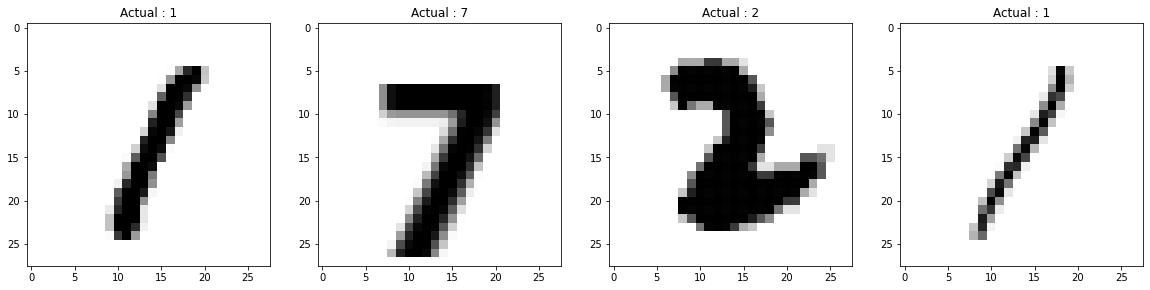

In [59]:
import matplotlib.pyplot as plt

x_train = X_train.reshape(X_train.shape[0], 28, 28)
fig, axis = plt.subplots(1, 4, figsize=(20,10))
for i, ax in enumerate(axis.flat):
    ax.imshow(x_train[i], cmap='binary')
    digit = Y_train[i].argmax()
    ax.set(title=f"Actual : {digit}")

In [60]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.callbacks import EarlyStopping
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils

model = Sequential()
model.add(Conv2D(32,(4,4),input_shape = (28,28,1),activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(64,(3,3),activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(10, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

In [61]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 25, 25, 32)        544       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 12, 12, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 10, 10, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 5, 5, 64)          0         
                                                                 
 flatten_2 (Flatten)         (None, 1600)             

In [62]:
model.fit(X_train, Y_train, validation_split=0.2, epochs=30, batch_size=92, verbose=2)

Epoch 1/30
501/501 - 14s - loss: 0.2410 - accuracy: 0.9252 - val_loss: 0.0813 - val_accuracy: 0.9763 - 14s/epoch - 28ms/step
Epoch 2/30
501/501 - 13s - loss: 0.0741 - accuracy: 0.9779 - val_loss: 0.0590 - val_accuracy: 0.9826 - 13s/epoch - 26ms/step
Epoch 3/30
501/501 - 14s - loss: 0.0528 - accuracy: 0.9841 - val_loss: 0.0684 - val_accuracy: 0.9805 - 14s/epoch - 29ms/step
Epoch 4/30
501/501 - 14s - loss: 0.0422 - accuracy: 0.9874 - val_loss: 0.0485 - val_accuracy: 0.9864 - 14s/epoch - 28ms/step
Epoch 5/30
501/501 - 14s - loss: 0.0351 - accuracy: 0.9894 - val_loss: 0.0420 - val_accuracy: 0.9878 - 14s/epoch - 28ms/step
Epoch 6/30
501/501 - 12s - loss: 0.0288 - accuracy: 0.9909 - val_loss: 0.0421 - val_accuracy: 0.9872 - 12s/epoch - 25ms/step
Epoch 7/30
501/501 - 15s - loss: 0.0248 - accuracy: 0.9918 - val_loss: 0.0447 - val_accuracy: 0.9873 - 15s/epoch - 29ms/step
Epoch 8/30
501/501 - 12s - loss: 0.0253 - accuracy: 0.9917 - val_loss: 0.0412 - val_accuracy: 0.9891 - 12s/epoch - 24ms/step


In [63]:
Y_pred = model.predict(X_test)

450/450 [==============================] - 1s 3ms/step


In [64]:
pred = np.array([x.argmax() for x in Y_pred])
test = np.array([x.argmax() for x in Y_test])

In [65]:
diff = [(x == 0) for x in (pred - test)]
len(diff) - np.sum(diff)

141

In [67]:
model.save('./trained_model')

INFO:tensorflow:Assets written to: ./trained_model\assets


INFO:tensorflow:Assets written to: ./trained_model\assets
